        
# CBO Applied to RL

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline
plt.style.use('default')
plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.dpi'] = 120

In [3]:
# hacky way of toggling between showing/hiding progress bar

# show
from tqdm.auto import tqdm, trange
# hide
# trange = lambda x, leave=None, desc=None: range(x)
# tqdm = lambda x, leave=None, desc=None: x

## $V$ -evaluation, continuous state space (5.1.)

### Outline

- Markov decision process with a continuous state space $\mathbb S = \{s \in (0, 2\pi]\}$.
- Dynamics described by 

$$
\begin{align}
&s_{m+1} = s_{m} + \alpha(s_m)\epsilon + \sigma(s_m)\sqrt{\epsilon} Z_m \\
&\alpha(s) = 2 \sin(s) \cos(s), \quad \sigma(s) = 1 + \cos(s)^2, \quad \epsilon = 0.1
\end{align}
$$

- Immediate reward function, $R(s)=(\cos(2s)+1)$.
- Discount factor $\gamma=0.9$.
- 3 layer FCNN, $V(s;\theta)$. Two hidden layers with $\cos$ activation function, and each hidden layer contains 50 neurons.

$$
\begin{align}
&V(s ; \theta)=V\left(x ;\left\{w_{i}, b_{i}\right\}_{i=1}^{3}\right)=L_{w_{3}, b_{3}} \circ \cos \circ L_{w_{2}, b_{2}} \circ \cos \circ L_{w_{1}, b_{1}}((\cos s, \sin s)) \\
&L_{w_{i}, b_{i}}(x)=w_{i} x+b_{i}, \quad w_{i} \in \mathbb{R}^{n_{i-1} \times n_{i}}, \quad b_{i} \in \mathbb{R}^{n_{i}}, \quad n_{0}=2, n_{1}=n_{2}=50, n_{3}=1
\end{align}
$$

- $\theta^*$ is computed with Algorithms 1-4 based on trajectory $\{s_m\}_{m=1}^{10^6}$ with

$$
f\left(s_{m}, s_{m+1}, \theta\right)=R\left(s_{m}\right)+\gamma V\left(s_{m+1} ; \theta\right)-V\left(s_{m} ; \theta\right), \quad \tau=0.1, \quad M=1000
$$

- The SGD algorithm runs for a single epoch with the same initialization $\theta_0$. 
- Error at step $k$, $e_k$ is defined as $e_k=\| V(\cdot,\theta_k)-V^*\|_{L^2}$. 
- Reference $V^*(s)$ is computed by running Algorithm 1 for 10 epochs based on longer trajectory $\{s_m\}_{m=1}^{10^7}$, with $\tau=0.01$, $M=1000$.
- Visualize $\log_{10}(e_k/e_0)$.

Made one modification to paper:
- Since $V(s,\theta)\mapsto V(s,\theta)+\delta$ is a symmetry in $f$, then a better way of measuring error, $e_k$, is 
$$
e_k=\| V(\cdot,\theta_k)-V^* - \mu_k \|_2,\quad \mu_k = \int V(\cdot,\theta_k)-V^*
$$

### Sampling Trajectory

In [4]:
def sample_trajectory(s_0, α, σ, ϵ, m):
    """
    samples trajectory of a particle following dSₜ = α(t) dt + σ(t) Wₜ, approximated by discrete units of time.
    
    parameters:
    s_0  : Starting state of particle
    α    : Drift function
    σ    : Noise scale function
    ϵ    : Step size
    m    : Number of steps to sample
    
    returns:
    S:   torch.tensor of sampled trajectory, with size (m, *s_0.size())
    """
    s_0_size = s_0.size()
    S = torch.zeros(m, *s_0_size)
    S[0] = s_0
    for i in range(m-1):
        S[i+1] = S[i]+α(S[i])*ϵ+σ(S[i])*torch.sqrt(ϵ)*torch.normal(mean=torch.zeros(*s_0_size))
    return S

In [5]:
α = lambda s: 2*torch.sin(s)*torch.cos(s) 
σ = lambda s: 1+torch.cos(s)**2
ϵ = torch.tensor([0.1])
s_0 = torch.tensor([0.])
r = lambda s: torch.cos(2*s)+1

In [6]:
# S = sample_trajectory(s_0, α, σ, ϵ, int(1e6))
# R = r(S) 
# S_long = sample_trajectory(s_0, α, σ, ϵ, int(1e7))
# R_long = r(S_long) 

In [7]:
# torch.save(S_long, 'S_long.pt')
# torch.save(R_long, 'R_long.pt')
# torch.save(S, 'S.pt')
# torch.save(R, 'R.pt')

In [6]:
S_long = torch.load('S_long.pt')
R_long = torch.load('R_long.pt')
S = torch.load('S.pt')
R = torch.load('R.pt')

In [9]:
# plt.plot(S,".",markersize=0.1);
# plt.xlabel(r"$i$");
# plt.ylabel(r"$s_i$");
# plt.show();
# plt.plot(torch.remainder(S,2*np.pi),".",markersize=0.1,alpha=0.1);
# plt.xlabel(r"$i$");
# plt.ylabel(r"$s_i$");
# plt.show();
# plt.plot(R,".",markersize=0.1,alpha=0.1);
# plt.xlabel(r"$i$");
# plt.ylabel(r"$R(s_i)$");
# plt.show();

### SGD

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 50) 
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.cat((torch.sin(x), torch.cos(x)), 1)
        x = torch.cos(self.fc1(x))
        x = torch.cos(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
def gen_batches(N, M, Rem):
    """
    generate random batches of indices, keeping track of remainders
    
    parameters:
    N   : number of elements to choose from
    M   : size of batches
    Rem : previous remainder
    
    returns:
    B   : tensor of batches, of size q,M 
    Rem : new remainder
    """
    P = torch.randperm(N)
    if Rem.size()[0] > 0:
        I = torch.cat((Rem, P), 0)
    else:
        I = P
    q = int(np.floor((P.size()[0]+Rem.size()[0])/M))
    B = I[:(q*M)].view(q, M)
    Rem = I[(q*M):]
    return B, Rem

In [9]:
def comp(V_net,V_net_comp,x_ls, n):
    diff = V_net(x_ls)-V_net_comp(x_ls)
    return np.sqrt(2*np.pi/n)*torch.norm(diff-torch.mean(diff))
def comp_0(V_net,V_net_comp,x_ls, n):
    return np.sqrt(2*np.pi/n)*torch.norm(V_net(x_ls)-V_net_comp(x_ls))

In [10]:
def V_eval_SGD_gen(update_step):
    def algo(V_net=Net(), M=1000, epochs=100, γ=0.9, τ=0.01, S=S, R=R, α=α, σ=σ, ϵ=ϵ, V_net_comp=None, n=100):
        Rem = torch.tensor([])
        N = S.size()[0]
        if V_net_comp:
            x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
            e = [comp(V_net,V_net_comp,x_ls, n)]
        for k in trange(epochs, leave=False, position=0, desc="Epoch"):
            B, Rem = gen_batches(N-2,M, Rem)
            for i,B_θ in enumerate(tqdm(B,leave=False, position=0,desc="Batch")): 
                update_step(V_net, γ, τ, S, R, B_θ,α=α, σ=σ, ϵ=ϵ)                
                with torch.no_grad():
                    for param in V_net.parameters():
                        param -= τ/M*param.grad
                if V_net_comp:
                    e.append(comp(V_net,V_net_comp,x_ls, n))
        if V_net_comp:
            return V_net, torch.tensor(e)
        else:
            return V_net
    return algo

In [11]:
def UR_SGD_update_step(V_net, γ, τ, S, R, B_θ, α=α, σ=σ, ϵ=ϵ):     
    s = S[B_θ]
    s_1 = S[B_θ+1]
    ŝ_1 = s+α(s)*ϵ+σ(s)*torch.sqrt(ϵ)*torch.normal(mean=torch.zeros_like(s))
    f_p = R[B_θ] + γ*V_net(ŝ_1) - V_net(s)
    f = R[B_θ] + γ*V_net(s_1) - V_net(s)
    V_net.zero_grad()
    f_p.backward(f)

def DS_SGD_update_step(V_net, γ, τ, S, R, B_θ, α=None, σ=None, ϵ=None):     
    s = S[B_θ]
    s_1 = S[B_θ+1]
    f = R[B_θ] + γ*V_net(s_1) - V_net(s)
    V_net.zero_grad()
    f.backward(f)

def BFF_G_SGD_update_step(V_net, γ, τ, S, R, B_θ, α=None, σ=None, ϵ=None):     
    s = S[B_θ]
    s_1 = S[B_θ+1]
    s_2 = S[B_θ+2]
    s̃_1 = s + s_2 - s_1 
    f = R[B_θ] + γ*V_net(s_1) - V_net(s)
    f̃ = R[B_θ] + γ*V_net(s̃_1) - V_net(s)
    V_net.zero_grad()
    (f*f̃).backward(torch.ones_like(f)/2.)
    
    
def BFF_L_SGD_update_step(V_net, γ, τ, S, R, B_θ, α=None, σ=None, ϵ=None):     
    s = S[B_θ]
    s_1 = S[B_θ+1]
    s_2 = S[B_θ+2]
    s̃_1 = s + s_2 - s_1 
    f = R[B_θ] + γ*V_net(s_1) - V_net(s)
    f̃ = R[B_θ] + γ*V_net(s̃_1) - V_net(s)
    V_net.zero_grad()
    f̃.backward(f)

In [ ]:
# V_UR_SGD_star = V_eval_SGD_gen(UR_SGD_update_step)(S=S_long, R=R_long, M=1000, epochs=10, τ=0.01)

In [12]:
# torch.save(V_UR_SGD_star, "V_UR_SGD_star.pt")
V_UR_SGD_star = torch.load("V_UR_SGD_star.pt")

In [16]:
V_UR_SGD, e_UR_SGD = V_eval_SGD_gen(UR_SGD_update_step)(M=1000, epochs=10, τ=0.01, V_net_comp = V_UR_SGD_star)
V_DS_SGD, e_DS_SGD = V_eval_SGD_gen(DS_SGD_update_step)(M=1000, epochs=10, τ=0.01, V_net_comp = V_UR_SGD_star)
V_BFF_G_SGD, e_BFF_G_SGD = V_eval_SGD_gen(BFF_G_SGD_update_step)(M=1000, epochs=10, τ=0.01, V_net_comp = V_UR_SGD_star)
V_BFF_L_SGD, e_BFF_L_SGD = V_eval_SGD_gen(BFF_L_SGD_update_step)(M=1000, epochs=10, τ=0.01, V_net_comp = V_UR_SGD_star)

Epoch: 100%|██████████| 10/10 [02:27<00:00, 13.92s/it]

In [18]:
def plotV(V_s, e_s, lb_s, V_star, lb_star):
    fig, axs = plt.subplots(figsize=(12,5),ncols=2)
    x_s = torch.linspace(0,2*np.pi,100)
    y_star = V_star(x_s.view(-1,1)).view(-1)
    y_s = torch.cat([V(x_s.view(-1,1)).view(1,-1) for V in V_s])
    y_s -= torch.mean(y_s-y_star.view(1,-1),axis=1).view(-1,1)
    axs[0].plot(x_s.detach().numpy(),y_star.detach().numpy(),label=lb_star,color="black")
    for j in range(0,len(y_s)):
        axs[0].plot(x_s.detach().numpy(),y_s[j].detach().numpy(),label=lb_s[j])
        axs[1].plot(e_s[j]/e_s[j][0], label=lb_s[j])
    axs[0].set_ylabel(r"$V(s)$")
    axs[0].set_xlabel(r"$s$")
    axs[1].set_yscale("log")
    axs[1].set_ylabel(r"$e_k/e_0$ (log scale)")
    axs[1].set_xlabel(r"$k$")
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right')
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)

In [19]:
V_s = [V_UR_SGD, V_DS_SGD, V_BFF_G_SGD, V_BFF_L_SGD]
e_s = [e_UR_SGD, e_DS_SGD, e_BFF_G_SGD, e_BFF_L_SGD]
lb_s = ["UR SGD", "D SGDS", "BFF Grad SGD", "BFF Loss SGD"]
lb_star = "UR* SGD"
plotV(V_s, e_s, lb_s, V_UR_SGD_star, lb_star)

NameError: name 'V_UR_SGD' is not defined

### CBO

In [51]:
def V_eval_CBO_gen(L_f):
    def algo(V_net=Net(), N=30, M=30, m=1000, epochs=100, S=S, α=α,σ=σ,ϵ=ϵ,γ=0.9,λ=1.,δ = 1e-3,g=1e3,
             τ_k=lambda k:0.1,η_k=lambda k:0.5, β_k=lambda k:10, V_net_comp=None, n_comp=100):
        with torch.no_grad():
            V_s = [Net() for _ in range(N)]
            Rem = torch.tensor([])
            rem = torch.tensor([])
            L = torch.empty(M)
            n = S.size()[0]
            if V_net_comp:
                x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
                e = [comp(V_net,V_net_comp,x_ls, n_comp)]
            for k in trange(epochs, leave=False, position=0, desc="Epoch"):
                B, Rem = gen_batches(N,M, Rem)
                A, rem = gen_batches(n-2,m, rem)
                β = β_k(k)
                τ = τ_k(k)  
                η = η_k(k)
                for i, B_θ in enumerate(tqdm(B,leave=False, position=0, desc="Batch")):
#                     A_θ = torch.randperm(n-2)[:m]
                    A_θ = A[i]
                    V_θ = [V_j for j,V_j in enumerate(V_s) if j in B_θ]
                    L = L_f(V_θ,A_θ, B_θ, m, γ, S=S,R=R, α=α,σ=σ, ϵ=ϵ)
                    μ = torch.exp(-β * L)
                    Δx̄ = 0 
                    for x̄X in zip(V_net.parameters(),*[V_j.parameters() for V_j in V_θ]):
                        x̄X_tensor = torch.cat([x̄X_j.view(1,-1) for x̄X_j in x̄X])
                        x̄_new = x̄X_tensor[0]
                        X_new = x̄X_tensor[1:]
                        x̄_new = μ.view(1,-1).mm(X_new)/torch.sum(μ)
                        Δx̄ += torch.norm(x̄X_tensor[0] - x̄_new)
                        X_new += -λ*η*(X_new-x̄_new)+τ*np.sqrt(η)*torch.normal(torch.zeros(X_new.size()))*(X_new-x̄_new)
                        x̄X_new = torch.cat((x̄_new,X_new)).view(-1, *x̄X[0].size())
                        for x̄X_j, x̄X_new_j in zip(x̄X,x̄X_new):
                            x̄X_j +=  x̄X_new_j - x̄X_j
                    if Δx̄<δ:
                        for X in zip(*[V_j.parameters() for V_j in V_θ]):
                            X_tensor = torch.cat([X_j.view(1,-1) for X_j in X])
                            X_new = X_tensor
                            X_new += g*τ*np.sqrt(η)*torch.normal(torch.zeros(X_new.size()))
                            X_new = X_new.view(-1, *X[0].size())
                            for X_j, X_new_j in zip(X,X_new):
                                X_j +=  X_new_j - X_j
                    if V_net_comp:
                        e.append(comp(V_net,V_net_comp,x_ls, n_comp))
            if V_net_comp:
                return V_net, torch.tensor(e)
            else:
                return V_net
    return algo

In [52]:
def UR_CBO_L(V_θ,A_θ, B_θ, m, γ, S=S,R=R, α=α,σ=σ, ϵ=ϵ):
    s = S[A_θ]
    s_1 = S[A_θ+1]
    s_2 = S[A_θ+2]
    ŝ_1 = s+α(s)*ϵ+σ(s)*torch.sqrt(ϵ)*torch.normal(mean=torch.zeros_like(s))
    f = torch.cat([R[A_θ] + γ*V_j(s_1)-V_j(s) for V_j in V_θ],1)
    f̂ = torch.cat([R[A_θ] + γ*V_j(ŝ_1)-V_j(s) for V_j in V_θ],1)
    return torch.sum(f*f̂,0)/(2*m)

def DS_CBO_L(V_θ,A_θ, B_θ, m, γ, S=S,R=R, α=None,σ=None, ϵ=None):
    s = S[A_θ]
    s_1 = S[A_θ+1]
    f = torch.cat([R[A_θ] + γ*V_j(s_1)-V_j(s) for V_j in V_θ],1)
    return torch.sum(f**2,0)/(2*m)

def BFF_CBO_L(V_θ,A_θ, B_θ, m, γ, S=S,R=R, α=None,σ=None, ϵ=None):
    s = S[A_θ]
    s_1 = S[A_θ+1]
    s_2 = S[A_θ+2]
    s̃_1 = s + s_2 - s_1
    f = torch.cat([R[A_θ] + γ*V_j(s_1)-V_j(s) for V_j in V_θ],1)
    f̃ = torch.cat([R[A_θ] + γ*V_j(s̃_1)-V_j(s) for V_j in V_θ],1)
    return torch.sum(f*f̃,0)/(2*m)

In [53]:
N = 30
M = 30
m = 1000
epochs = 500
g = 1e4
η_k = lambda k: 0.5*0.998**k
τ_k = lambda k: 0.1*0.998**k
β_k = lambda k: 30*1.02**k

In [16]:
V_UR_CBO, e_UR_CBO = V_eval_CBO_gen(UR_CBO_L)(N=N, M=M, m=m,epochs=epochs, η_k=η_k, τ_k=τ_k, β_k=β_k,g=g, V_net_comp = V_UR_SGD_star)
V_DS_CBO, e_DS_CBO = V_eval_CBO_gen(DS_CBO_L)(N=N, M=M, m=m,epochs=epochs, η_k=η_k, τ_k=τ_k, β_k=β_k, g=g, V_net_comp = V_UR_SGD_star)
V_BFF_CBO, e_BFF_CBO = V_eval_CBO_gen(BFF_CBO_L)(N=N, M=M, m=m,epochs=epochs, η_k=η_k, τ_k=τ_k, β_k=β_k, g=g,V_net_comp = V_UR_SGD_star)

Epoch: 100%|██████████| 500/500 [04:16<00:00,  1.94it/s]

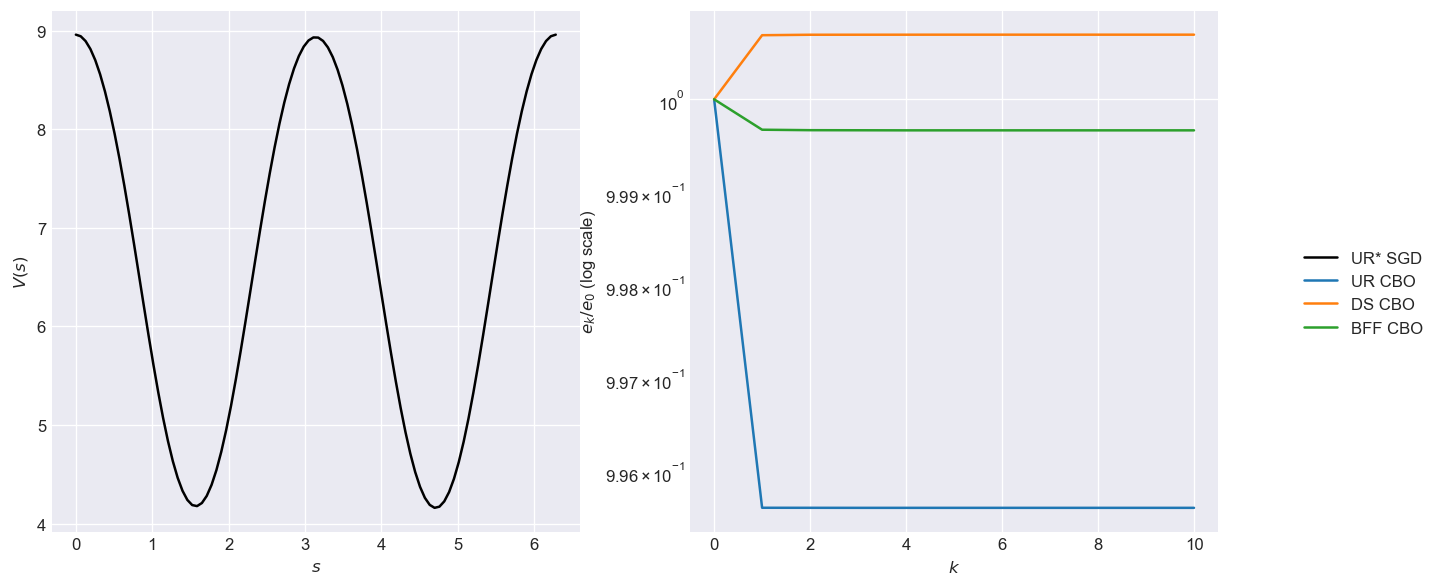

In [20]:
V_s = [V_UR_CBO, V_DS_CBO, V_BFF_CBO]
e_s = [e_UR_CBO, e_DS_CBO, e_BFF_CBO]
lb_s = ["UR CBO", "DS CBO", "BFF CBO"]
lb_star = "UR* SGD"
plotV(V_s, e_s, lb_s, V_UR_SGD_star, lb_star)

In [1]:
N = 100 
M = 100
m = 1000
epochs = 1000
g = 1e4
η_k = lambda k: max(0.005*0.99985**k,0.001)
τ_k = lambda k: max(5*0.995**k, 0.01)
β_k = lambda k: min(50*1.0025**k,400.)

In [44]:
N = 30
M = 30
m = 1000
epochs = 750
λ = 1.
g = 1e4
η_k = lambda k: 0.05*0.9999**k
τ_k = lambda k: 2.1*0.9999**k
β_k = lambda k: 30*1.0001**k  

In [45]:
print(η_k(epochs), τ_k(epochs), β_k(epochs))

0.04615563268412307 1.9385365727331691 32.49848204472595


In [46]:
V_UR_CBO, e_UR_CBO = V_eval_CBO_gen(UR_CBO_L)(N=N, M=M, m=m,epochs=epochs, η_k=η_k, τ_k=τ_k, β_k=β_k,g=g, V_net_comp = V_UR_SGD_star)
V_DS_CBO, e_DS_CBO = V_eval_CBO_gen(DS_CBO_L)(N=N, M=M, m=m,epochs=epochs, η_k=η_k, τ_k=τ_k, β_k=β_k, g=g, V_net_comp = V_UR_SGD_star)
V_BFF_CBO, e_BFF_CBO = V_eval_CBO_gen(BFF_CBO_L)(N=N, M=M, m=m,epochs=epochs, η_k=η_k, τ_k=τ_k, β_k=β_k, g=g, V_net_comp = V_UR_SGD_star)

Epoch: 100%|██████████| 800/800 [04:36<00:00,  1.82it/s]

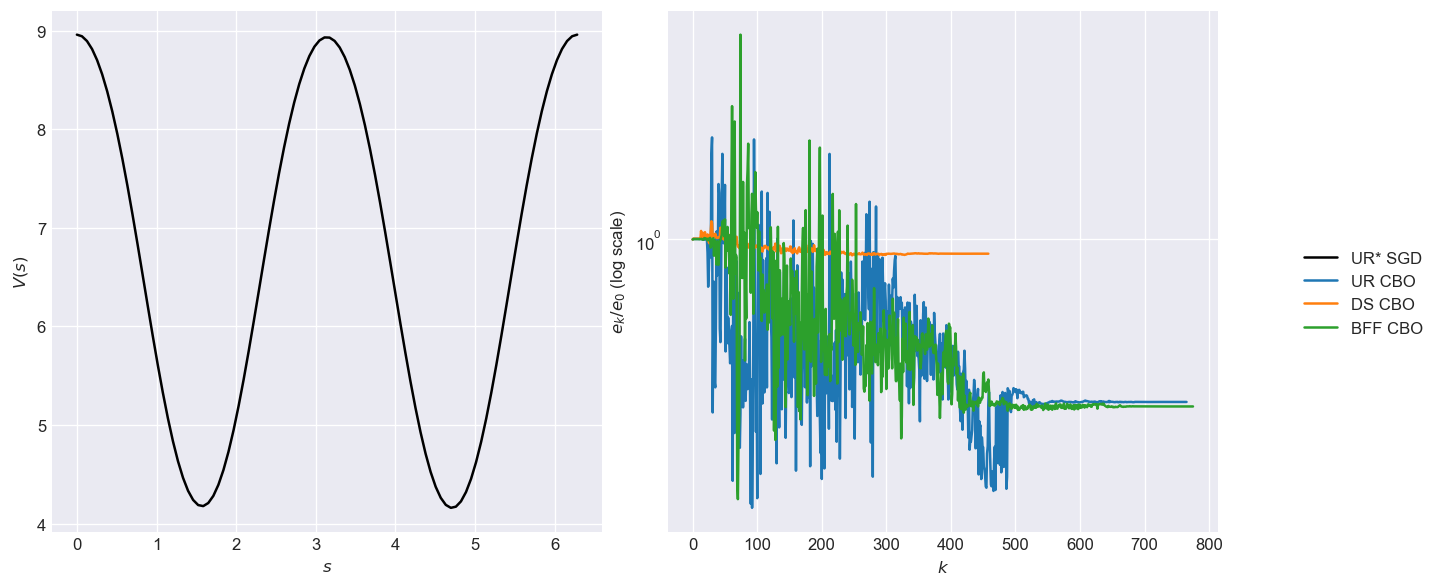

In [48]:
V_s = [V_UR_CBO, V_DS_CBO, V_BFF_CBO]
e_s = [e_UR_CBO, e_DS_CBO, e_BFF_CBO]
lb_s = ["UR CBO", "DS CBO", "BFF CBO"] 
lb_star = "UR* SGD"
plotV(V_s, e_s, lb_s, V_UR_SGD_star, lb_star)